In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("Train_v2.csv")
test = pd.read_csv("Test_v2.csv")
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [3]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


# Explolatory Data Analysis
*This is the process of finding some insights from you dataset before create predictive models.*

Note: This is important steps in your Data science workflow.

## Let see the statistical overview of our dataset

In [4]:
# describe will show statistical info
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


From the above cell we can see that most of our features are categorical because ony 3 columns are numerical that's why it shows only those 3 with the mean, count, standard deviation also the minimum value of each columns the maximum value of each columns along with the interquartile range

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


From this info method we got to know more about our data it first show us the number of non null count als the datatype of each columns along with the total number of each datatypes we have. It shows here that we have 3 features with *int* dataypte and 10 *objects* datatype also it tell us about the size of the file we have which is in our case 2.3MB

In [6]:
# to show the shape of the data
train.shape

(23524, 13)

### Target Distribution

<AxesSubplot:xlabel='bank_account', ylabel='count'>

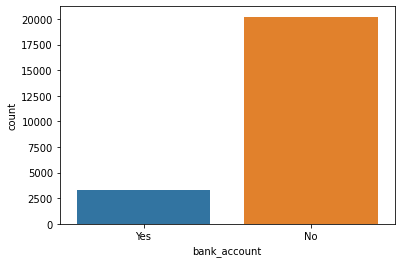

In [7]:
sns.countplot(train.bank_account)

From the above cell we can see that we have unbalanced data basically the number of No is much higher than the number of yes which can lead to poor model performence sometimes. In this can we've about 2500 yes and 20000 No which gives us a big difference later on we will what we can do for this .

### Let's see the percentage of missing data

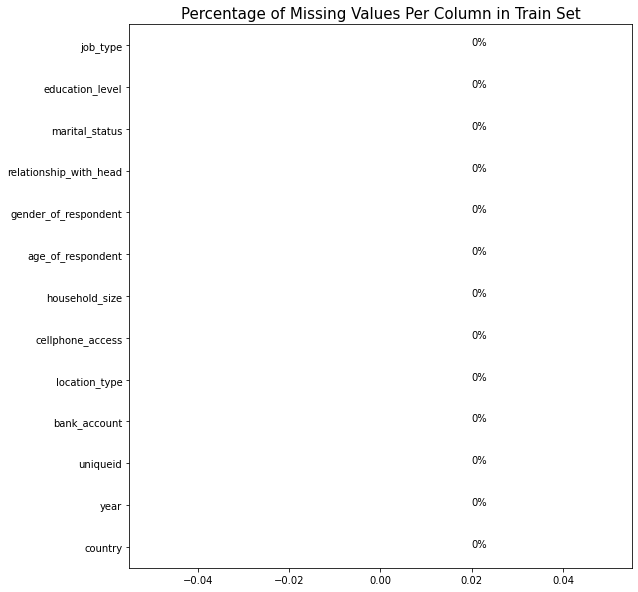

In [8]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind="barh", figsize=(9, 10))
plt.title("Percentage of Missing Values Per Column in Train Set", fontdict={"size": 15})
for p in ax.patches:
    percentage = "{:,.0f}%".format((p.get_width() / train.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height / 2
    ax.annotate(percentage, (x, y))

It shows that we don't have any missing values which is good

### Let's see the disctribution of the people with cellphone based on gender.

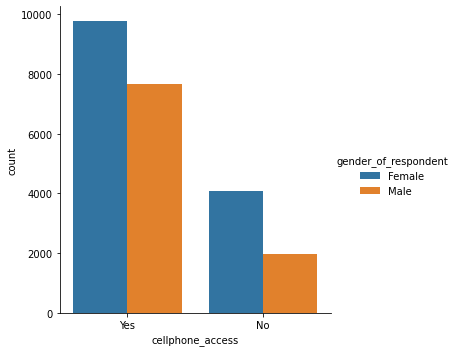

In [9]:
sns.catplot(x="cellphone_access", data=train, kind="count", hue="gender_of_respondent")
plt.show()

This shows that number of male having cellphones is higher than the numbero female in this case.

## Let's see the distribution of age

<AxesSubplot:xlabel='age_of_respondent', ylabel='Density'>

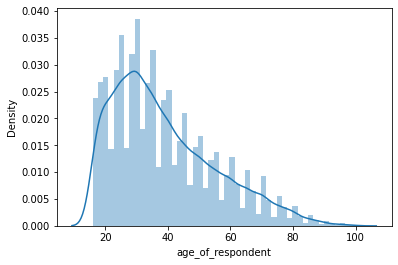

In [10]:
sns.distplot(train.age_of_respondent)

This distribution make sense because we have age range from 16 years old to 100 year

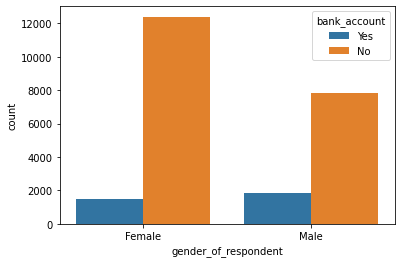

In [11]:
# Distribution of the gender
sns.countplot(train.gender_of_respondent, hue="bank_account", data=train)
plt.show()

we can see that the number of female that have bank account is higher than the number of male with a bank account. 

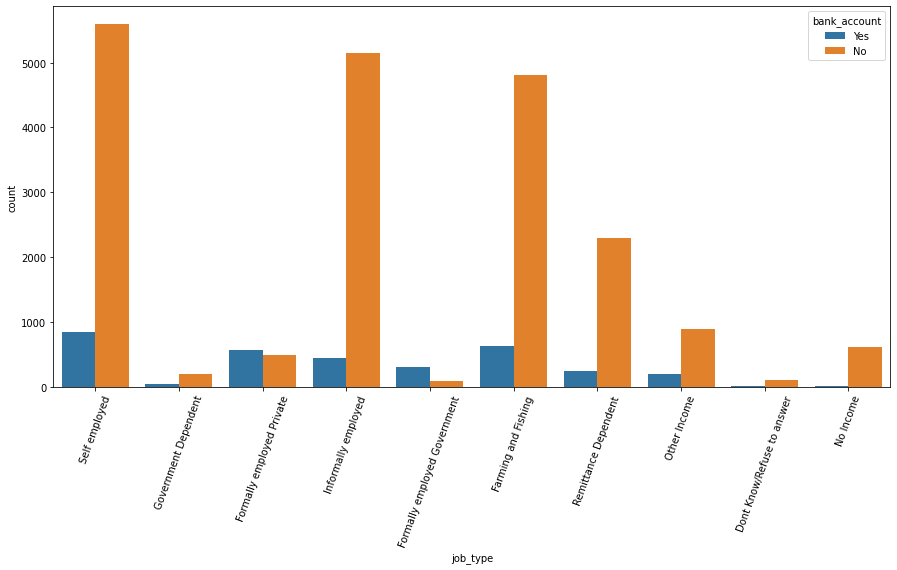

In [12]:
# distribution of job type
plt.figure(figsize=(15, 7))
sns.countplot(train.job_type, orient="h", hue="bank_account", data=train)
labels = [
    "Self employed",
    "Government Dependent",
    "Formally employed Private",
    "Informally employed",
    "Formally employed Government",
    "Farming and Fishing",
    "Remittance Dependent",
    "Other Income",
    "Dont Know/Refuse to answer",
    "No Income",
]
ax = plt.gca()
ax.set_xticklabels(labels=labels, rotation=70);

we can see from the above graph the the people who are self employed and farming and fishing are those who are more likely to have bank account as compare to the those who work for the Government or other income. 
We can notice also those who don't have no Income and does who reuse to answer don't have high chance of having bank account.

<AxesSubplot:xlabel='location_type', ylabel='count'>

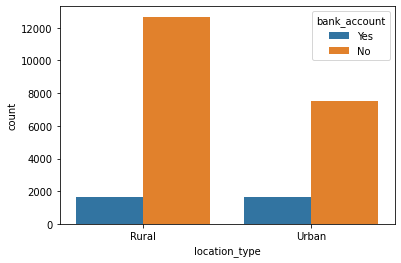

In [13]:
# Distribution of the location based on account
sns.countplot(train.location_type, hue="bank_account", data=train)

We can see that people in Urban area is have more chance to have bank_account than those who are in Rural area although we can see also the number people in Rural area is higher.

<AxesSubplot:xlabel='household_size', ylabel='count'>

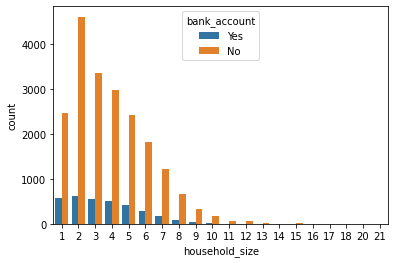

In [14]:
# Distirbution of the household_size
sns.countplot(train.household_size, hue="bank_account", data=train)

## How many people have cellphone

In [15]:
train.cellphone_access.value_counts()[0]

17454

we can see that the number of people who have cellphone access is 17454 which is more than the half which make more sense in this case

### How many types of education do the dataset has?

In [16]:
train.education_level.unique()

array(['Secondary education', 'No formal education',
       'Vocational/Specialised training', 'Primary education',
       'Tertiary education', 'Other/Dont know/RTA'], dtype=object)

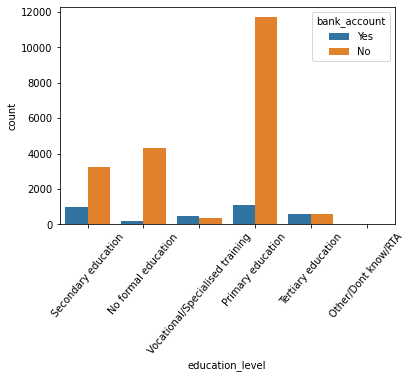

In [17]:
sns.countplot(train.education_level, hue="bank_account", data=train)
labels = [
    "Secondary education",
    "No formal education",
    "Vocational/Specialised training",
    "Primary education",
    "Tertiary education",
    "Other/Dont know/RTA",
]
ax = plt.gca()
ax.set_xticklabels(labels=labels, rotation=50);

we can see that the vocational/ specialised training is the majority in this case and we have few people with No formal education

In [18]:
train.marital_status.value_counts()

Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: marital_status, dtype: int64

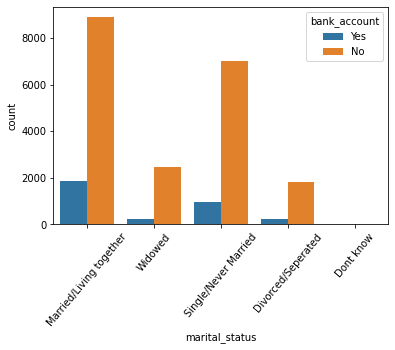

In [19]:
sns.countplot(train.marital_status, hue="bank_account", data=train)
labels = [
    "Married/Living together",
    "Widowed",
    "Single/Never Married",
    "Divorced/Seperated",
    "Dont know",
]
ax = plt.gca()
ax.set_xticklabels(labels=labels, rotation=50);

This shows that people who are married and living together are more likely to have a bank account as compare to ther slike single or divorced

In [20]:
# import preprocessing module
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Convert target label to numerical Data
le = LabelEncoder()
train["bank_account"] = le.fit_transform(train["bank_account"])

# Separate training features from target
X = train.drop(["bank_account", "uniqueid"], axis=1)
y = train["bank_account"]

X.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [21]:
X.shape

(23524, 11)

In [22]:
# function to preprocess our data from train models


def preprocessing_data(data):

    # Convert the following numerical labels from integer to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(
        float
    )

    # categorical features to be converted by One Hot Encoding
    categ = [
        "relationship_with_head",
        "marital_status",
        "education_level",
        "job_type",
        "country",
    ]

    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)

    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])

    # drop uniquid column
    # data = data.drop(["uniqueid"], axis=1)

    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    return data

In [23]:
X = preprocessing_data(X)

In [24]:
# target
y.head()

0    1
1    0
2    1
3    0
4    0
Name: bank_account, dtype: int64

In [25]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1.0,0.0,1.0,0.10,0.095238,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.20,0.642857,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.20,0.119048,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.20,0.214286,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.35,0.119048,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = LGBMClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=300,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.8509192633969822

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.8414918953398949

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.8457645656091155

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.8627342435625043

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.8520227938967129

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.8534997331643126

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.8415444479491023

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.8469177862055666

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 9 Score: 0.8415848096497351

|||||||||||||||||||||

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [36]:
params = {
    "objective": "binary",
    "n_estimators": 20000,
    "max_depth": 8,
    "learning_rate": 0.01,
    "min_child_weight": 256,
    "min_child_samples": 15,
    "reg_alpha": 10,
    "reg_lambda": 0.1,
    "subsample": 1,
    "subsample_freq": 1,
    "colsample_bytree": 0.4,
}

In [40]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = XGBClassifier()

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=300,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

[14:23:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold: 1 Score: 0.8670756752889837

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[14:23:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold: 2 Score: 0.8629510620413371

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[14:23:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold: 3 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, stratify=y_train
)

print("Train/Valid/Test sizes:", y_train.shape[0], y_valid.shape[0], y_test.shape[0])

Train/Valid/Test sizes: 16466 3294 7058


In [43]:
import numpy as np
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=123)

params = {
    "min_samples_split": scipy.stats.randint(2, 12),
    "min_impurity_decrease": scipy.stats.uniform(0.0, 0.5),
    "max_depth": [6, 16, None],
}


search = RandomizedSearchCV(
    estimator=clf, param_distributions=params, n_iter=50, cv=10, verbose=2, n_jobs=1
)


search.fit(X_train, y_train)

search.best_score_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_split=4; total time=   0.0s
[CV] END max_depth=16, min_impurity_decrease=0.014364197838983073, min_samples_sp

0.8609861739116964

In [44]:
search.best_params_

{'max_depth': 16,
 'min_impurity_decrease': 0.014364197838983073,
 'min_samples_split': 4}

In [45]:
print(f"Training Accuracy: {search.best_estimator_.score(X_train, y_train):0.2f}")
print(f"Test Accuracy: {search.best_estimator_.score(X_test, y_test):0.2f}")

Training Accuracy: 0.86
Test Accuracy: 0.86


In [47]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=123)

boost = XGBClassifier(random_state=123, verbosity=0, use_label_encoder=False)

metaclassifier = LogisticRegression(random_state=123)

sclf = StackingCVClassifier(
    classifiers=[forest, boost], meta_classifier=metaclassifier, random_state=123
)

# Random_forest

In [48]:
forest.fit(X_train_sub, y_train_sub)
print(f"Training Accuracy: {forest.score(X_train_sub, y_train_sub):0.2f}")
print(f"Validation Accuracy: {forest.score(X_valid, y_valid):0.2f}")
print(f"Test Accuracy: {forest.score(X_test, y_test):0.2f}")

Training Accuracy: 0.98
Validation Accuracy: 0.86
Test Accuracy: 0.87


# Gradient boosting

In [49]:
boost.fit(X_train_sub, y_train_sub)
print(f"Training Accuracy: {boost.score(X_train_sub, y_train_sub):0.2f}")
print(f"Validation Accuracy: {boost.score(X_valid, y_valid):0.2f}")
print(f"Test Accuracy: {boost.score(X_test, y_test):0.2f}")

Training Accuracy: 0.92
Validation Accuracy: 0.88
Test Accuracy: 0.88


# stacking

In [51]:
import numpy as np
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(sclf)

params = {
    "stackingcvclassifier__use_probas": [True],
    "stackingcvclassifier__drop_proba_col": [None, "last"],
    "stackingcvclassifier__xgbclassifier__reg_alpha": scipy.stats.loguniform(1e-5, 1),
    "stackingcvclassifier__xgbclassifier__max_depth": [2, 4, 6, 8],
    "stackingcvclassifier__randomforestclassifier__n_estimators": [10, 100],
}


search = RandomizedSearchCV(
    estimator=pipe, param_distributions=params, n_iter=50, cv=10, verbose=2, n_jobs=1
)

search.fit(X_train, y_train)
search.best_score_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=10, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=0.0007363402527607932; total time=   4.4s
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=10, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=0.0007363402527607932; total time=   4.0s
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=10, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=0.0007363402527607932; total time=   4.1s
[CV] END stackingcvclassifier__drop_proba_col=last, stacki

0.8877072050438184

In [52]:
search.best_params_

{'stackingcvclassifier__drop_proba_col': None,
 'stackingcvclassifier__randomforestclassifier__n_estimators': 10,
 'stackingcvclassifier__use_probas': True,
 'stackingcvclassifier__xgbclassifier__max_depth': 2,
 'stackingcvclassifier__xgbclassifier__reg_alpha': 0.001304861306934654}

In [53]:
print(f"Training Accuracy: {search.best_estimator_.score(X_train, y_train):0.2f}")
print(f"Test Accuracy: {search.best_estimator_.score(X_test, y_test):0.2f}")

Training Accuracy: 0.90
Test Accuracy: 0.89
